In [1]:
import sys
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from glob import glob
import numpy as np
import torch
from random import shuffle
import random
from numpy import random as npr
import pandas as pd
import imageio
from PIL import Image


class MethaneLoader(DataLoader):

    def __init__(self, device, mode, plume_id, red=False, alli=False, channels=12):
        self.device = device
        self.mode = mode
        self.reduce = red
        self.channels = channels

        if mode == "train":
            persist = False
        else:
            persist = True
        
        if plume_id is not None:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/*/{}.npy".format(mode, plume_id)))
#             self.neg_labels = sorted(
#                 glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/{}.npy".format(mode, plume_id)))
            self.neg_labels = []
        else:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/*.npy".format(mode)))
            self.neg_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/neg/*.npy".format(mode)))

        self.labels = self.pos_labels+self.neg_labels  # None
        
        if not alli:
            self.sample_labels_and_combine(persist=persist)

    def sample_labels_and_combine(self, persist=False):
        """
        Sample a subset of negative labels for each epoch
        """
        # if self.mode == "test":
        if self.mode in ["val"]:
            self.labels = self.pos_labels+self.neg_labels
        else:
            if persist:
                random.seed(555)

            shuffle(self.neg_labels)
            self.labels = self.pos_labels + \
                self.neg_labels[:len(self.pos_labels)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        f = self.labels[index]
        # print(f)

        plume_id = int(f.split("/")[-1].split(".")[0])
        # print(plume_id)

        target = np.load(f)
        context = np.load(
            "/kaggle/input/ch4net-dataset/data/{}/s2/{}.npy".format(self.mode, plume_id))

        if self.channels == 2:
            context = context[..., 10:]
        if self.channels == 5:
            context = np.concatenate(
                [context[..., 1:4], context[..., 10:]], axis=-1)
        
        if self.mode == "train":
            # rotate by 90, 180, 270 degrees
            degrees = npr.choice([0, 90, 180, 270])
            context = np.rot90(context, k=degrees//90)
            target = np.rot90(target, k=degrees//90)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=0)
                target = np.flip(target, axis=0)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=1)
                target = np.flip(target, axis=1)

        # Crop to centre
        # x_c = target.shape[0]//2
        # y_c = target.shape[1]//2
        s = 64

        if self.mode == "train":
            rng = npr.RandomState()
            mid_loc_x = rng.randint(s, target.shape[0]-s)
            mid_loc_y = rng.randint(s, target.shape[1]-s)

        else:
            mid_loc_x = target.shape[0]//2
            mid_loc_y = target.shape[1]//2

        target = target[mid_loc_x-s:mid_loc_x+s,
                        mid_loc_y-s: mid_loc_y+s]

        context = context[mid_loc_x-s:mid_loc_x+s,
                          mid_loc_y-s: mid_loc_y+s, :]

        ### These are not defined before and not necessary for training. 
        ### But these are used in evaluation outputs
#         diff_img = np.array(diff_img[mid_loc_x-s:mid_loc_x+s,
#                                      mid_loc_y-s:mid_loc_y+s, :])
#         diff_img_g = np.array(diff_img_g[mid_loc_x-s:mid_loc_x+s,
#                                          mid_loc_y-s:mid_loc_y+s])
#         rgb_img = np.array(rgb_img[mid_loc_x-s:mid_loc_x+s,
#                                    mid_loc_y-s:mid_loc_y+s, :])

        if self.reduce:
            target = np.array([np.int(target.any())])

        # if self.mode == "test":
            # print("Plume ID: {}, date: {}".format(plume_id, date))

        d = {"pred": torch.from_numpy(context.copy()).float().to(self.device).permute(2, 0, 1)/255,
             "target": torch.from_numpy(target.copy()).float().to(self.device)}
        
        # Print the size of the image tensor
#         print("Image tensor size (context):", d["pred"].size())
#         print("Image tensor size (target):", d["target"].size())

        return d

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    """
    Base MLP module with ReLU activation
    Parameters:
    -----------
    in_channels: Int
        Number of input channels
    out_channels: Int
        Number of output channels
    h_channels: Int
        Number of hidden channels
    h_layers: Int
        Number of hidden layers
    """

    def __init__(self, 
                in_channels, 
                out_channels, 
                h_channels=64,
                h_layers=4):

        super().__init__()

        def hidden_block(h_channels):
            h = nn.Sequential(
            nn.Linear(h_channels, h_channels),
            nn.ReLU())
            return h

        # Model
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.ReLU(),
            *[hidden_block(h_channels) for _ in range(h_layers)],
            nn.Linear(h_channels, out_channels) 
        )

    def forward(self, x):
        return self.mlp(x)

class Unet(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 div_factor=8,
                 prob_output=True,
                 class_output=False

    ):
        super(Unet, self).__init__()

        self.n_channels = in_channels
        self.bilinear = True
        self.sigmoid = nn.Sigmoid()
        self.prob_output = prob_output
        self.class_output = class_output

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                # [?, C, H, W]
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1) ## why 1?
                return self.conv(x)

        self.inc = double_conv(self.n_channels, 64//div_factor)
        self.down1 = down(64//div_factor, 128//div_factor)
        self.down2 = down(128//div_factor, 256//div_factor)
        self.down3 = down(256//div_factor, 512//div_factor)
        self.down4 = down(512//div_factor, 512//div_factor)
        self.up1 = up(1024//div_factor, 256//div_factor)
        self.up2 = up(512//div_factor, 128//div_factor)
        self.up3 = up(256//div_factor, 64//div_factor)
        self.up4 = up(128//div_factor, 128//div_factor)
        self.out = nn.Conv2d(128//div_factor, 1, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        #return self.out(x).permute(0,2,3,1)

        if self.prob_output:
            x = self.out(x)
            return self.sigmoid(x).permute(0,2,3,1)
        else:
            return self.out(x).permute(0,2,3,1)

In [3]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class UNet_Attention(nn.Module):
    def __init__(self, img_ch=12, output_ch=1):
        super(UNet_Attention, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

# Example usage:

# Instantiate the model
model = UNet_Attention(img_ch=12, output_ch=1)

# Example input tensor with shape [batch_size, channels, height, width]
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16

# Example target tensor with shape [batch_size, height, width]
target_tensor = torch.randn(16, 128, 128)

# Adjust the target tensor to match the output shape
target_tensor = target_tensor.unsqueeze(1)

# Forward pass
output = model(input_tensor)

# Check output shape
print(f"Output shape: {output.shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]

Output shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [4]:
import torch
import torch.nn as nn

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [5]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(out_ch))

    def forward(self, x):
        x = self.conv1(x) + self.conv2(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class Res_UNet_Channel_Attention(nn.Module):
    def __init__(self, img_ch=12, output_ch=1):
        super(Res_UNet_Channel_Attention, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16, n1 * 32]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])
        self.conv6 = conv_block(filters[4], filters[5])

        self.Up6 = up_conv(filters[5], filters[4])
        self.Att6 = Attention_block(F_g=filters[4], F_l=filters[4], F_int=filters[3])
        self.Up_conv6 = conv_block(filters[5], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)
        
        self.Ch_att1 = ChannelAttention(in_planes=filters[0], ratio=8)
        self.Ch_att2 = ChannelAttention(in_planes=filters[1], ratio=8)
        self.Ch_att3 = ChannelAttention(in_planes=filters[2], ratio=8)
        self.Ch_att4 = ChannelAttention(in_planes=filters[3], ratio=8)
        self.Ch_att5 = ChannelAttention(in_planes=filters[4], ratio=8)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        e6 = self.Maxpool5(e5)
        e6 = self.conv6(e6)

        d6 = self.Up6(e6)

#         x5 = self.Att6(g=d6, x=self.Ch_att5(e5))
        x5 = self.Att6(g=d6, x=e5)
        d6 = torch.cat((x5, d6), dim=1)
        d6 = self.Up_conv6(d6)

        d5 = self.Up5(d6)
#         x4 = self.Att5(g=d5, x=self.Ch_att4(e4))
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
#         x3 = self.Att4(g=d4, x=self.Ch_att3(e3))
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
#         x2 = self.Att3(g=d3, x=self.Ch_att2(e2))
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
#         x1 = self.Att2(g=d2, x=self.Ch_att1(e1))
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

# Example usage:

# Instantiate the model
model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)

# Example input tensor with shape [batch_size, channels, height, width]
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16

# Example target tensor with shape [batch_size, height, width]
target_tensor = torch.randn(16, 128, 128)

# Adjust the target tensor to match the output shape
target_tensor = target_tensor.unsqueeze(1)

# Forward pass
output = model(input_tensor)

# Check output shape
print(f"Output shape: {output.shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]

Output shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [6]:
from matplotlib import pyplot as plt
import torch
import scipy
import numpy as np
from tqdm import tqdm
from torch import autograd
from torch.utils.data import DataLoader
# from loader import *


class Trainer():
    """
    Training class for the neural process models
    """

    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 train_dataset,
                 loss_function,
                 save_path,
                 learning_rate):

        # Model and data
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.train_dataset = train_dataset
        self.save_path = save_path

        # Training parameters
        self.loss_function = loss_function
        self.opt = torch.optim.Adam(list(self.model.parameters()) + list(self.loss_function.parameters()), lr=learning_rate)
        self.sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt, mode='min', factor=0.5, patience=7, verbose=True)

        # Losses
        self.losses = []
        self.mIoUs = []

    def plot_losses(self):
        """
        Plot losses and IoUs in same figure
        """
        
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color=color)
        ax1.plot(self.losses, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('mIoU', color=color)
        ax2.plot(self.mIoUs, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()
        plt.show()

    def _unravel_to_numpy(self, x):
        return x.view(-1).detach().cpu().numpy()

    def eval_epoch(self, verbose=False):

        self.model.eval()
        lf = []
        ious = []

        outs = []
        ts = []

        def calculate_iou(pred, target):
            eps = 1e-6
            # convert to sigmoid then to binary
            pred = F.sigmoid(pred)
            pred = (pred > 0.5).float()
            target = target.float()
            
            return (torch.sum(pred * target) + eps) / (torch.sum(pred + target) + eps)
        
        with torch.no_grad():
            for task in self.val_loader:

                out = self.model(task["pred"])
                lf.append(self.loss_function(np.squeeze(out), task["target"]))
                ious.append(calculate_iou(out, task["target"]))
                outs.append(out.detach().cpu().numpy())
                ts.append(task["target"].detach().cpu().numpy())

        # Get loss function
        log_loss = torch.mean(torch.tensor(lf))
        print("- Log loss: {}".format(log_loss))
        mIoU = torch.mean(torch.tensor(ious))
        print("- mIoU: {}".format(mIoU))

        if verbose:
            return log_loss, np.concatenate(outs, axis=0), np.concatenate(ts, axis=0)

        return log_loss, mIoU

    def train(self, n_epochs=100):

        # Init progress bar
        best_loss = 100000
        best_model_state_dict = None
        best_opt_state_dict = None
        i = 1

        for epoch in range(n_epochs):

            autograd.set_detect_anomaly(True)

            print("Training epoch {}".format(epoch))

            if epoch < 500:
                self.model.train()
                self.train_dataset.sample_labels_and_combine()
                self.train_loader = DataLoader(self.train_dataset,
                                               batch_size=16,
                                               shuffle=True)

            with tqdm(self.train_loader, unit="batch") as tepoch:
                for task in tepoch:

                    out = self.model(task["pred"])

                    # print("loss")
                    loss = self.loss_function(np.squeeze(out), task["target"])

                    loss.backward()
                    self.opt.step()
                    self.opt.zero_grad()
                    # print("out")
                    tepoch.set_postfix(loss=loss.item())
                epoch_loss, mIoU = self.eval_epoch(verbose=False)
                self.sched.step(epoch_loss)
#                 print(self.sched.get_last_lr())

            if np.logical_or(epoch_loss <= best_loss, epoch >= 1000):
                #                 torch.save({
                #                     'epoch': epoch,
                #                     'model_state_dict': self.model.state_dict(),
                #                     'optimizer_state_dict': self.opt.state_dict(),
                #                     'loss': epoch_loss
                #                 }, self.save_path+"epoch_{}".format(epoch))
                best_model_state_dict = self.model.state_dict()
                best_opt_state_dict = self.opt.state_dict()
                best_loss = epoch_loss
#                 np.save("outs.npy", o)
#                 np.save("ts.npy", t)

            self.losses.append(epoch_loss)
            self.mIoUs.append(mIoU)

            # checkpoint
            if i % 20 == 0 or i == n_epochs:
                np.save(self.save_path+"losses.npy", np.array(self.losses))
                self.plot_losses()

                torch.save({
                    # 'epoch': epoch,
                    'model_state_dict': best_model_state_dict,
                    'optimizer_state_dict': best_opt_state_dict,
                    'loss': best_loss
                }, self.save_path+"final_model".format(epoch))
            i += 1

        print("Training complete!")

In [7]:
!mkdir -p /kaggle/working/train_out
!mkdir -p /kaggle/working/eval_out

In [8]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.4 MB/s eta 0:00:00a 0:00:01


In [9]:
import torch
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss
from monai.losses.hausdorff_loss import HausdorffDTLoss

def loss(pred, target):
#     print(pred.shape, target.shape)
    bce_loss = nn.BCEWithLogitsLoss(reduction="none") 
    ll = bce_loss(pred, target)

    ll = ll.sum(dim=(-2,-1)) #*mask
    return ll.mean()


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce_loss = nn.BCEWithLogitsLoss(reduction="none")
    
    def forward(self, pred, target):
        loss = self.bce_loss(pred, target)
        prob = torch.sigmoid(pred)  # Predicted probability
        alpha = torch.where(target == 1, self.alpha, 1 - self.alpha)  # Class balancing factor
        focal_weight = torch.where(target == 1, 1 - prob, prob)  # Focusing weight
        focal_weight = alpha * focal_weight**self.gamma  # Apply alpha and gamma
        focal_loss = focal_weight * loss
        
        focal_loss = focal_loss.sum(dim=(-2,-1)) #*mask
        
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss

    
class MultiScalePoolingLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2, itr=3, ratio=None):
        super(MultiScalePoolingLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.itr = itr
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma)
        self.ratio = torch.tensor(ratio)
    
    def forward(self, pred, target):
        losses = torch.zeros(self.itr)
        if(pred.dim() == 2):
            pred = pred.unsqueeze(0)
            target = target.unsqueeze(0)
        elif(pred.dim() == 3):
            pred = pred.unsqueeze(1)
            target = target.unsqueeze(1)
        for i in range(self.itr):
            losses[i] = self.focal_loss(pred, target)
            pred = F.max_pool2d(pred, kernel_size=2, stride=2)
            target = F.max_pool2d(target, kernel_size=2, stride=2)
        
        if self.ratio is not None:
            losses = losses * self.ratio
        else:
            losses = losses * 1/self.itr
        
        return torch.sum(losses)

    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        # Flatten label and prediction tensors
        inputs = inputs.view(inputs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        
        # Compute Dice loss
        intersection = (inputs * targets).sum(dim=1)
        dice_loss = 1 - (2.0 * intersection + smooth) / (inputs.sum(dim=1) + targets.sum(dim=1) + smooth)

        # Compute BCE loss
        BCE = F.binary_cross_entropy(inputs, targets, reduction='none')
        BCE = BCE.mean(dim=1)

        # Combine Dice and BCE losses
        Dice_BCE = BCE + dice_loss

        return Dice_BCE.mean()

    
class HausdorffDT_Loss(nn.Module):
    def __init__(self):
        super(HausdorffDT_Loss, self).__init__()
        self.hd_loss = HausdorffDTLoss(reduction='mean', sigmoid=True)
        self.focal_loss = FocalLoss

    def forward(self, inputs, targets):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        return self.hd_loss(inputs.unsqueeze(1), targets.unsqueeze(1))

# Adaptive weighting based on loss gradients:
# Adaptive Loss Combination
# This approach uses the gradients of each loss with respect to a learnable parameter to determine their relative importance.
# The weight is determined by the ratio of these gradients, ensuring that the loss with the larger gradient 
# (and thus potentially more room for improvement) gets more weight.
class HausdorffDT_Focal_Loss(nn.Module):
    def __init__(self, focal_weight = 0.65, alpha=0.5, momentum=0.9):
        super(HausdorffDT_Focal_Loss, self).__init__()
        self.hd_loss = HausdorffDTLoss(reduction='none', sigmoid=True)
        self.focal_loss = FocalLoss(alpha=0.75, gamma=2.0, reduction='none')
        self.focal_weight = focal_weight
        self.alpha = nn.Parameter(torch.tensor(alpha))
        self.momentum = momentum
        self.register_buffer('moving_focal', torch.tensor(0.0))
        self.register_buffer('moving_hausdorff', torch.tensor(0.0))
        
    def forward(self, inputs, targets):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        hl = self.hd_loss(inputs.unsqueeze(1), targets.unsqueeze(1))
        fl = self.focal_loss(inputs, targets)
        # final_loss = self.focal_weight * torch.squeeze(fl) + (1-self.focal_weight) * torch.squeeze(hl)
        
        # Ensure losses are scalars
        focal_loss = torch.mean(fl)
        hausdorff_loss = torch.mean(hl)

        # Update moving averages
        self.moving_focal = self.momentum * self.moving_focal + (1 - self.momentum) * focal_loss.detach()
        self.moving_hausdorff = self.momentum * self.moving_hausdorff + (1 - self.momentum) * hausdorff_loss.detach()

        # Compute relative loss magnitudes
        total_loss = self.moving_focal + self.moving_hausdorff
        focal_ratio = self.moving_focal / total_loss
        hausdorff_ratio = self.moving_hausdorff / total_loss

        # Adjust alpha based on moving averages
        self.alpha.data = torch.clamp(hausdorff_ratio, 0.1, 0.9)

        # Compute weighted loss
        loss = self.alpha * focal_loss + (1 - self.alpha) * hausdorff_loss

        return loss
        
        # return torch.mean(combined_loss)
    

# pred = torch.randn(16, 1, 128, 128).float()
# target = torch.randint(0, 2, (16, 1, 128, 128)).float()

# # focal_loss = FocalLoss(alpha=0.75, gamma=1.0)
# # hausdorffDTLoss = HausdorffDT_Loss(reduction='none', sigmoid=True)
# # dbceloss = DiceBCELoss()
# # multi_scale_pooling_loss = MultiScalePoolingLoss(alpha=0.75, gamma=2.0, itr=3, ratio=[0.5, 0.3, 0.2])
# hausdorffDT_focal_loss = HausdorffDT_Focal_Loss(focal_weight = 0.65)

# # focal_loss(pred, target)
# # multi_scale_pooling_loss(pred, target)
# print(hausdorffDT_focal_loss(pred, target))

/opt/conda/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


Training epoch 0


  0%|          | 0/75 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/monai/losses/hausdorff_loss.py:171: UserWarning: single channel prediction, `include_background=False` ignored.
  warnings.warn("single channel prediction, `include_background=False` ignored.")
100%|██████████| 75/75 [00:58<00:00,  1.28batch/s, loss=159]


- Log loss: 207.34695434570312
- mIoU: 0.0008306975942105055
Training epoch 1


100%|██████████| 75/75 [00:35<00:00,  2.09batch/s, loss=91.6]


- Log loss: 107.6267318725586
- mIoU: 5.6737768318271264e-05
Training epoch 2


100%|██████████| 75/75 [00:33<00:00,  2.21batch/s, loss=105] 


- Log loss: 77.54264068603516
- mIoU: 0.0005207566427998245
Training epoch 3


100%|██████████| 75/75 [00:33<00:00,  2.22batch/s, loss=76.1]


- Log loss: 72.54732513427734
- mIoU: 0.0011400310322642326
Training epoch 4


100%|██████████| 75/75 [00:33<00:00,  2.26batch/s, loss=79.3]


- Log loss: 64.71788024902344
- mIoU: 0.0007783370674587786
Training epoch 5


100%|██████████| 75/75 [00:32<00:00,  2.33batch/s, loss=83.4]


- Log loss: 45.434059143066406
- mIoU: 0.00015415719826705754
Training epoch 6


100%|██████████| 75/75 [00:32<00:00,  2.33batch/s, loss=93]  


- Log loss: 49.737648010253906
- mIoU: 0.0018758842488750815
Training epoch 7


100%|██████████| 75/75 [00:31<00:00,  2.36batch/s, loss=55.4]


- Log loss: 48.462703704833984
- mIoU: 0.0005979228299111128
Training epoch 8


100%|██████████| 75/75 [00:31<00:00,  2.39batch/s, loss=74.8]


- Log loss: 46.68684768676758
- mIoU: 0.00046211565495468676
Training epoch 9


100%|██████████| 75/75 [00:33<00:00,  2.26batch/s, loss=65.4]


- Log loss: 47.9620475769043
- mIoU: 0.00354581605643034
Training epoch 10


100%|██████████| 75/75 [00:30<00:00,  2.48batch/s, loss=60]  


- Log loss: 69.98553466796875
- mIoU: 0.00911320187151432
Training epoch 11


100%|██████████| 75/75 [00:29<00:00,  2.52batch/s, loss=82.8]


- Log loss: 40.0123405456543
- mIoU: 0.0009323279955424368
Training epoch 12


100%|██████████| 75/75 [00:30<00:00,  2.48batch/s, loss=85.8]


- Log loss: 57.364864349365234
- mIoU: 0.0032318311277776957
Training epoch 13


100%|██████████| 75/75 [00:32<00:00,  2.28batch/s, loss=41.1]


- Log loss: 36.852867126464844
- mIoU: 0.00047229681513272226
Training epoch 14


100%|██████████| 75/75 [00:29<00:00,  2.58batch/s, loss=50.7]


- Log loss: 42.25968551635742
- mIoU: 0.0016290585044771433
Training epoch 15


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=53.2]


- Log loss: 40.15943908691406
- mIoU: 0.0063115255907177925
Training epoch 16


100%|██████████| 75/75 [00:28<00:00,  2.61batch/s, loss=35.5]


- Log loss: 38.90768051147461
- mIoU: 0.005045228637754917
Training epoch 17


100%|██████████| 75/75 [00:28<00:00,  2.59batch/s, loss=55.9]


- Log loss: 35.85344696044922
- mIoU: 0.0012093884870409966
Training epoch 18


100%|██████████| 75/75 [00:32<00:00,  2.33batch/s, loss=34.9]


- Log loss: 40.3525505065918
- mIoU: 0.007275457959622145
Training epoch 19


100%|██████████| 75/75 [00:32<00:00,  2.34batch/s, loss=18.5]


- Log loss: 35.58833694458008
- mIoU: 0.008456554263830185


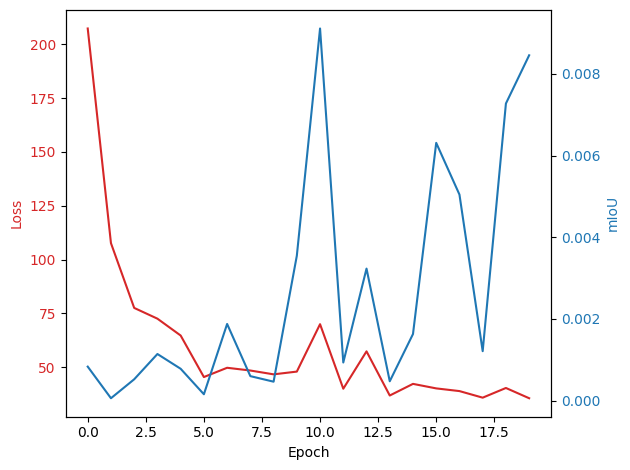

Training epoch 20


100%|██████████| 75/75 [00:33<00:00,  2.23batch/s, loss=36.7]


- Log loss: 34.131221771240234
- mIoU: 0.004396115429699421
Training epoch 24


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=32.6]


- Log loss: 38.94500732421875
- mIoU: 0.014437971636652946
Training epoch 25


100%|██████████| 75/75 [00:27<00:00,  2.73batch/s, loss=67.6]


- Log loss: 34.292083740234375
- mIoU: 0.0053820484317839146
Training epoch 26


100%|██████████| 75/75 [00:27<00:00,  2.74batch/s, loss=33]  


- Log loss: 48.76817321777344
- mIoU: 0.026379676535725594
Training epoch 27


100%|██████████| 75/75 [00:26<00:00,  2.79batch/s, loss=35.1]


- Log loss: 39.756446838378906
- mIoU: 0.020616978406906128
Training epoch 28


100%|██████████| 75/75 [00:27<00:00,  2.69batch/s, loss=38.1]


- Log loss: 39.390380859375
- mIoU: 0.009550324641168118
Training epoch 29


100%|██████████| 75/75 [00:27<00:00,  2.73batch/s, loss=32.4]


- Log loss: 41.07804870605469
- mIoU: 0.02698812261223793
Training epoch 30


100%|██████████| 75/75 [00:27<00:00,  2.78batch/s, loss=50]  


- Log loss: 33.356075286865234
- mIoU: 0.0176959540694952
Training epoch 31


100%|██████████| 75/75 [00:26<00:00,  2.81batch/s, loss=21.5]


- Log loss: 37.91498565673828
- mIoU: 0.014759077690541744
Training epoch 32


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=47.4]


- Log loss: 31.865474700927734
- mIoU: 0.014054916799068451
Training epoch 33


100%|██████████| 75/75 [00:26<00:00,  2.78batch/s, loss=37.8]


- Log loss: 32.814292907714844
- mIoU: 0.02571752667427063
Training epoch 34


100%|██████████| 75/75 [00:27<00:00,  2.70batch/s, loss=15.5]


- Log loss: 35.23871994018555
- mIoU: 0.02961711212992668
Training epoch 38


100%|██████████| 75/75 [00:27<00:00,  2.71batch/s, loss=48.2]


- Log loss: 32.37366485595703
- mIoU: 0.02079062908887863
Training epoch 39


100%|██████████| 75/75 [00:27<00:00,  2.70batch/s, loss=42.4]


- Log loss: 29.342891693115234
- mIoU: 0.014187615364789963


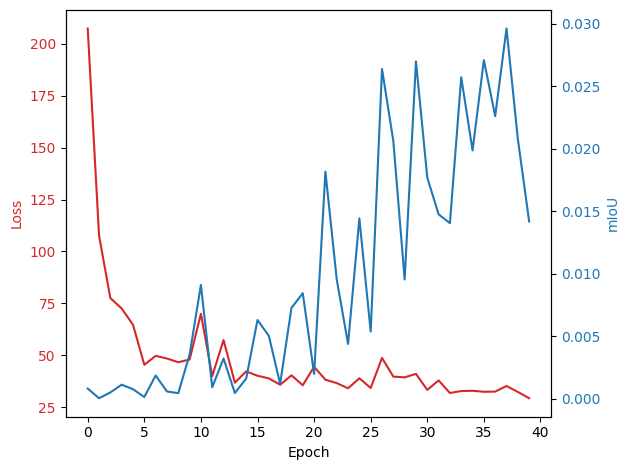

Training epoch 40


100%|██████████| 75/75 [00:29<00:00,  2.56batch/s, loss=39]  


- Log loss: 39.088497161865234
- mIoU: 0.033742327243089676
Training epoch 41


100%|██████████| 75/75 [00:27<00:00,  2.72batch/s, loss=29.8]


- Log loss: 32.07903289794922
- mIoU: 0.024904921650886536
Training epoch 42


100%|██████████| 75/75 [00:28<00:00,  2.62batch/s, loss=23.5]


- Log loss: 27.58908462524414
- mIoU: 0.03294307366013527
Training epoch 43


100%|██████████| 75/75 [00:29<00:00,  2.57batch/s, loss=21.9]


- Log loss: 33.904788970947266
- mIoU: 0.021325021982192993
Training epoch 44


100%|██████████| 75/75 [00:27<00:00,  2.74batch/s, loss=32.2]


- Log loss: 28.75497055053711
- mIoU: 0.027823416516184807
Training epoch 45


100%|██████████| 75/75 [00:28<00:00,  2.67batch/s, loss=24.2]


- Log loss: 35.352142333984375
- mIoU: 0.016965121030807495
Training epoch 46


100%|██████████| 75/75 [00:27<00:00,  2.69batch/s, loss=23.6]


- Log loss: 33.02369689941406
- mIoU: 0.024724014103412628
Training epoch 47


100%|██████████| 75/75 [00:28<00:00,  2.65batch/s, loss=20.7]


- Log loss: 30.810131072998047
- mIoU: 0.02898409031331539
Training epoch 48


100%|██████████| 75/75 [00:27<00:00,  2.68batch/s, loss=28.7]


- Log loss: 31.016845703125
- mIoU: 0.02647393010556698
Training epoch 49


100%|██████████| 75/75 [00:27<00:00,  2.75batch/s, loss=21.7]


- Log loss: 26.902700424194336
- mIoU: 0.03736777976155281
Training epoch 50


100%|██████████| 75/75 [00:27<00:00,  2.74batch/s, loss=32.1]


- Log loss: 32.03294372558594
- mIoU: 0.02678789012134075
Training epoch 51


100%|██████████| 75/75 [00:27<00:00,  2.71batch/s, loss=46.5]


- Log loss: 29.253631591796875
- mIoU: 0.033336326479911804
Training epoch 52


100%|██████████| 75/75 [00:26<00:00,  2.79batch/s, loss=40.4]


- Log loss: 27.703638076782227
- mIoU: 0.039411935955286026
Training epoch 53


100%|██████████| 75/75 [00:27<00:00,  2.72batch/s, loss=15.5]


- Log loss: 29.374027252197266
- mIoU: 0.053915202617645264
Training epoch 54


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=27.6]


- Log loss: 29.036876678466797
- mIoU: 0.038763757795095444
Training epoch 55


100%|██████████| 75/75 [00:27<00:00,  2.74batch/s, loss=14.3]


- Log loss: 26.371183395385742
- mIoU: 0.026572685688734055
Training epoch 56


100%|██████████| 75/75 [00:27<00:00,  2.72batch/s, loss=25.6]


- Log loss: 28.39149284362793
- mIoU: 0.03483571484684944
Training epoch 57


100%|██████████| 75/75 [00:27<00:00,  2.76batch/s, loss=19.5]


- Log loss: 27.7752628326416
- mIoU: 0.037504229694604874
Training epoch 58


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=27.5]


- Log loss: 30.773109436035156
- mIoU: 0.029195982962846756
Training epoch 59


100%|██████████| 75/75 [00:27<00:00,  2.75batch/s, loss=22.6]


- Log loss: 27.649822235107422
- mIoU: 0.03546297550201416


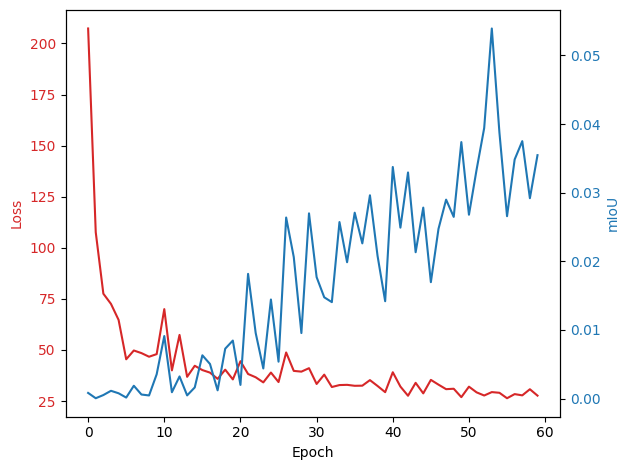

Training epoch 60


100%|██████████| 75/75 [00:26<00:00,  2.81batch/s, loss=31.6]


- Log loss: 27.873868942260742
- mIoU: 0.03902198746800423
Training epoch 61


100%|██████████| 75/75 [00:34<00:00,  2.16batch/s, loss=15]  


- Log loss: 27.541555404663086
- mIoU: 0.03310303017497063
Training epoch 62


100%|██████████| 75/75 [00:26<00:00,  2.79batch/s, loss=20.8]


- Log loss: 28.09543800354004
- mIoU: 0.029777254909276962
Training epoch 63


100%|██████████| 75/75 [00:30<00:00,  2.50batch/s, loss=31.5]


- Log loss: 31.692846298217773
- mIoU: 0.03740067407488823
Training epoch 64


100%|██████████| 75/75 [00:28<00:00,  2.66batch/s, loss=25.2]


- Log loss: 26.095247268676758
- mIoU: 0.03681055083870888
Training epoch 65


100%|██████████| 75/75 [00:26<00:00,  2.81batch/s, loss=21.6]


- Log loss: 25.855009078979492
- mIoU: 0.03850632905960083
Training epoch 66


100%|██████████| 75/75 [00:26<00:00,  2.79batch/s, loss=12]  


- Log loss: 25.59048080444336
- mIoU: 0.03651212900876999
Training epoch 67


100%|██████████| 75/75 [00:27<00:00,  2.71batch/s, loss=12.2]


- Log loss: 24.680734634399414
- mIoU: 0.038586102426052094
Training epoch 68


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=19.3]


- Log loss: 23.47920799255371
- mIoU: 0.04134495556354523
Training epoch 69


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=12.9]


- Log loss: 23.636219024658203
- mIoU: 0.04206009581685066
Training epoch 70


100%|██████████| 75/75 [00:27<00:00,  2.71batch/s, loss=7.7] 


- Log loss: 22.122119903564453
- mIoU: 0.036089345812797546
Training epoch 71


100%|██████████| 75/75 [00:33<00:00,  2.27batch/s, loss=24.9]


- Log loss: 24.50231170654297
- mIoU: 0.03916233777999878
Training epoch 72


100%|██████████| 75/75 [00:36<00:00,  2.06batch/s, loss=12.1]


- Log loss: 23.767234802246094
- mIoU: 0.03955450281500816
Training epoch 73


100%|██████████| 75/75 [00:35<00:00,  2.10batch/s, loss=12]  


- Log loss: 23.950002670288086
- mIoU: 0.037959180772304535
Training epoch 74


100%|██████████| 75/75 [00:37<00:00,  2.02batch/s, loss=10.2]


- Log loss: 23.99240493774414
- mIoU: 0.03973895311355591
Training epoch 75


100%|██████████| 75/75 [00:30<00:00,  2.49batch/s, loss=15.2]


- Log loss: 25.002866744995117
- mIoU: 0.038640428334474564
Training epoch 76


100%|██████████| 75/75 [00:28<00:00,  2.62batch/s, loss=16]  


- Log loss: 24.9981689453125
- mIoU: 0.03909633681178093
Training epoch 77


100%|██████████| 75/75 [00:27<00:00,  2.72batch/s, loss=10.4]


- Log loss: 22.09439468383789
- mIoU: 0.04155270382761955
Training epoch 78


100%|██████████| 75/75 [00:26<00:00,  2.81batch/s, loss=34.3]


- Log loss: 24.348556518554688
- mIoU: 0.034886788576841354
Training epoch 79


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=10.6]


- Log loss: 22.527616500854492
- mIoU: 0.03957591950893402


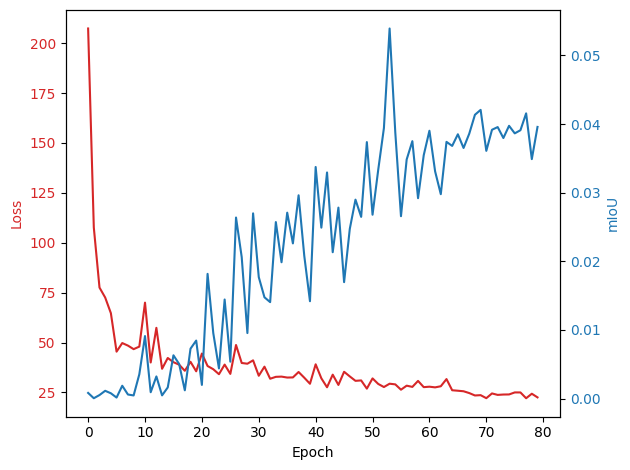

Training epoch 80


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=14.3]


- Log loss: 25.75581169128418
- mIoU: 0.0429009310901165
Training epoch 81


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=14.2]


- Log loss: 23.12862777709961
- mIoU: 0.045571357011795044
Training epoch 82


100%|██████████| 75/75 [00:29<00:00,  2.56batch/s, loss=8.92]


- Log loss: 22.812408447265625
- mIoU: 0.03753989189863205
Training epoch 83


100%|██████████| 75/75 [00:26<00:00,  2.78batch/s, loss=14.7]


- Log loss: 23.14188575744629
- mIoU: 0.035920340567827225
Training epoch 84


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=18.3]


- Log loss: 24.64134979248047
- mIoU: 0.03817504644393921
Training epoch 85


100%|██████████| 75/75 [00:27<00:00,  2.74batch/s, loss=13.4]


- Log loss: 24.524240493774414
- mIoU: 0.041199397295713425
Training epoch 86


100%|██████████| 75/75 [00:26<00:00,  2.79batch/s, loss=5.58]


- Log loss: 23.399810791015625
- mIoU: 0.04089602828025818
Training epoch 87


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=10.3]


- Log loss: 25.324752807617188
- mIoU: 0.039541274309158325
Training epoch 88


100%|██████████| 75/75 [00:27<00:00,  2.71batch/s, loss=18]  


- Log loss: 23.38086700439453
- mIoU: 0.040538959205150604
Training epoch 89


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=11.3]


- Log loss: 22.763713836669922
- mIoU: 0.04022401198744774
Training epoch 90


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=12.7]


- Log loss: 22.960636138916016
- mIoU: 0.040437001734972
Training epoch 91


100%|██████████| 75/75 [00:28<00:00,  2.66batch/s, loss=10.6]


- Log loss: 22.422407150268555
- mIoU: 0.043216973543167114
Training epoch 92


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=12.7]


- Log loss: 22.215240478515625
- mIoU: 0.04344158247113228
Training epoch 93


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=20.6]


- Log loss: 25.53114891052246
- mIoU: 0.04402582347393036
Training epoch 94


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=12.5]


- Log loss: 21.90237808227539
- mIoU: 0.04419102892279625
Training epoch 95


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=23.3]


- Log loss: 21.625728607177734
- mIoU: 0.040474940091371536
Training epoch 96


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=6.16]


- Log loss: 21.084333419799805
- mIoU: 0.04313237592577934
Training epoch 97


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=7.36]


- Log loss: 22.16238784790039
- mIoU: 0.04363293573260307
Training epoch 98


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=11.9]


- Log loss: 23.97423553466797
- mIoU: 0.042917151004076004
Training epoch 99


100%|██████████| 75/75 [00:27<00:00,  2.70batch/s, loss=10.4]


- Log loss: 22.246906280517578
- mIoU: 0.03934823349118233


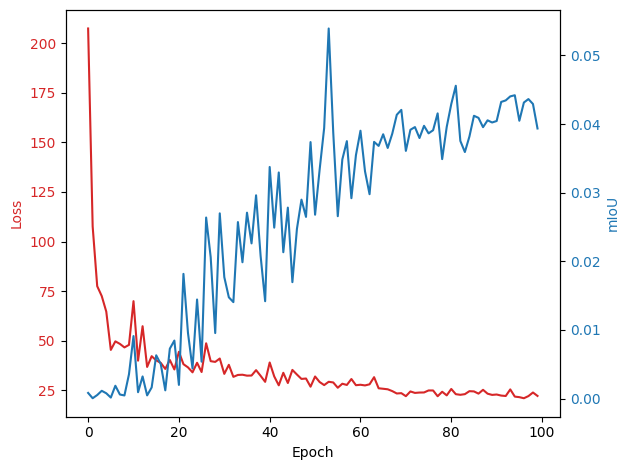

Training epoch 100


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=17.3]


- Log loss: 22.970182418823242
- mIoU: 0.04298762232065201
Training epoch 101


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=12.4]


- Log loss: 22.286806106567383
- mIoU: 0.04090661182999611
Training epoch 102


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=13.7]


- Log loss: 22.542442321777344
- mIoU: 0.045660629868507385
Training epoch 103


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=12.5]


- Log loss: 22.298133850097656
- mIoU: 0.039483003318309784
Training epoch 104


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=13.6]


- Log loss: 22.960817337036133
- mIoU: 0.04290786013007164
Training epoch 105


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=6.24]


- Log loss: 21.63895606994629
- mIoU: 0.045242056250572205
Training epoch 106


100%|██████████| 75/75 [00:26<00:00,  2.86batch/s, loss=9.33]


- Log loss: 22.316638946533203
- mIoU: 0.044500015676021576
Training epoch 107


100%|██████████| 75/75 [00:26<00:00,  2.85batch/s, loss=10.2]


- Log loss: 21.302827835083008
- mIoU: 0.04536454379558563
Training epoch 108


100%|██████████| 75/75 [00:27<00:00,  2.72batch/s, loss=9.57]


- Log loss: 21.989131927490234
- mIoU: 0.044658202677965164
Training epoch 109


100%|██████████| 75/75 [00:26<00:00,  2.78batch/s, loss=5.19]


- Log loss: 21.443317413330078
- mIoU: 0.043547045439481735
Training epoch 110


100%|██████████| 75/75 [00:27<00:00,  2.76batch/s, loss=6.91]


- Log loss: 21.621917724609375
- mIoU: 0.044540759176015854
Training epoch 111


100%|██████████| 75/75 [00:28<00:00,  2.66batch/s, loss=7.81]


- Log loss: 21.842601776123047
- mIoU: 0.0419016107916832
Training epoch 112


100%|██████████| 75/75 [00:34<00:00,  2.16batch/s, loss=15.1]


- Log loss: 22.723546981811523
- mIoU: 0.04409559443593025
Training epoch 113


100%|██████████| 75/75 [00:34<00:00,  2.20batch/s, loss=16.6]


- Log loss: 21.909677505493164
- mIoU: 0.04007342457771301
Training epoch 114


100%|██████████| 75/75 [00:27<00:00,  2.73batch/s, loss=12.9]


- Log loss: 21.763927459716797
- mIoU: 0.043876923620700836
Training epoch 115


100%|██████████| 75/75 [00:28<00:00,  2.65batch/s, loss=9.1] 


- Log loss: 22.379119873046875
- mIoU: 0.04318724945187569
Training epoch 116


100%|██████████| 75/75 [00:26<00:00,  2.84batch/s, loss=10.9]


- Log loss: 22.14426612854004
- mIoU: 0.04385177418589592
Training epoch 117


100%|██████████| 75/75 [00:31<00:00,  2.41batch/s, loss=11.6]


- Log loss: 21.324684143066406
- mIoU: 0.043035414069890976
Training epoch 118


100%|██████████| 75/75 [00:28<00:00,  2.67batch/s, loss=9.27]


- Log loss: 21.98173713684082
- mIoU: 0.043663788586854935
Training epoch 119


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=8.2] 


- Log loss: 21.508209228515625
- mIoU: 0.044872235506772995


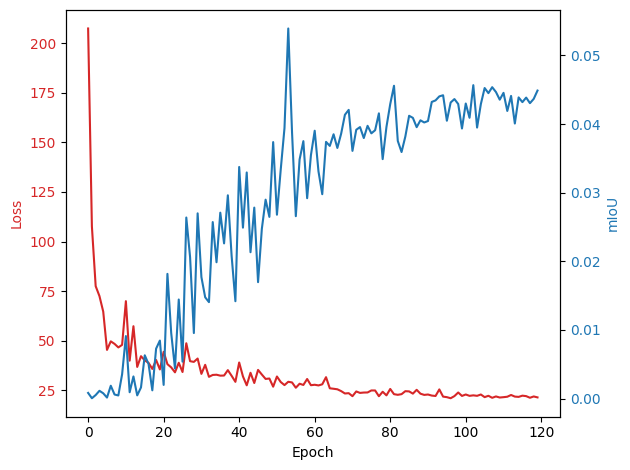

Training epoch 120


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=13.2]


- Log loss: 21.638465881347656
- mIoU: 0.045061852782964706
Training epoch 121


100%|██████████| 75/75 [00:27<00:00,  2.75batch/s, loss=4.33]


- Log loss: 21.44180679321289
- mIoU: 0.04274556785821915
Training epoch 122


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=11]  


- Log loss: 21.50125503540039
- mIoU: 0.042107295244932175
Training epoch 123


100%|██████████| 75/75 [00:26<00:00,  2.78batch/s, loss=21.5]


- Log loss: 21.62725257873535
- mIoU: 0.04495803266763687
Training epoch 124


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=8.62]


- Log loss: 21.915910720825195
- mIoU: 0.043206702917814255
Training epoch 125


100%|██████████| 75/75 [00:26<00:00,  2.78batch/s, loss=11.1]


- Log loss: 21.242700576782227
- mIoU: 0.04463253170251846
Training epoch 126


100%|██████████| 75/75 [00:29<00:00,  2.53batch/s, loss=5.65]


- Log loss: 21.757802963256836
- mIoU: 0.04375256225466728
Training epoch 127


100%|██████████| 75/75 [00:26<00:00,  2.78batch/s, loss=11]  


- Log loss: 20.861474990844727
- mIoU: 0.04445621743798256
Training epoch 128


100%|██████████| 75/75 [00:30<00:00,  2.49batch/s, loss=7.67]


- Log loss: 22.44724464416504
- mIoU: 0.043875936418771744
Training epoch 129


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=13.5]


- Log loss: 21.560243606567383
- mIoU: 0.04533248394727707
Training epoch 130


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=9.83]


- Log loss: 22.43090057373047
- mIoU: 0.04366159439086914
Training epoch 131


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=12.6]


- Log loss: 21.61933135986328
- mIoU: 0.04429159685969353
Training epoch 132


100%|██████████| 75/75 [00:26<00:00,  2.83batch/s, loss=7.7] 


- Log loss: 21.429229736328125
- mIoU: 0.04451030120253563
Training epoch 133


100%|██████████| 75/75 [00:27<00:00,  2.77batch/s, loss=9.85]


- Log loss: 21.98124885559082
- mIoU: 0.04268616810441017
Training epoch 134


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=11.9]


- Log loss: 21.57244873046875
- mIoU: 0.043661512434482574
Training epoch 135


100%|██████████| 75/75 [00:26<00:00,  2.79batch/s, loss=15.5]


- Log loss: 21.664825439453125
- mIoU: 0.04429909214377403
Training epoch 136


100%|██████████| 75/75 [00:27<00:00,  2.76batch/s, loss=10.5]


- Log loss: 22.239187240600586
- mIoU: 0.042422425001859665
Training epoch 137


100%|██████████| 75/75 [00:26<00:00,  2.82batch/s, loss=9.79]


- Log loss: 21.856185913085938
- mIoU: 0.04388628527522087
Training epoch 138


100%|██████████| 75/75 [00:28<00:00,  2.63batch/s, loss=6.79]


- Log loss: 21.463903427124023
- mIoU: 0.044253159314394
Training epoch 139


100%|██████████| 75/75 [00:31<00:00,  2.38batch/s, loss=10.9]


- Log loss: 21.30030059814453
- mIoU: 0.0421878807246685


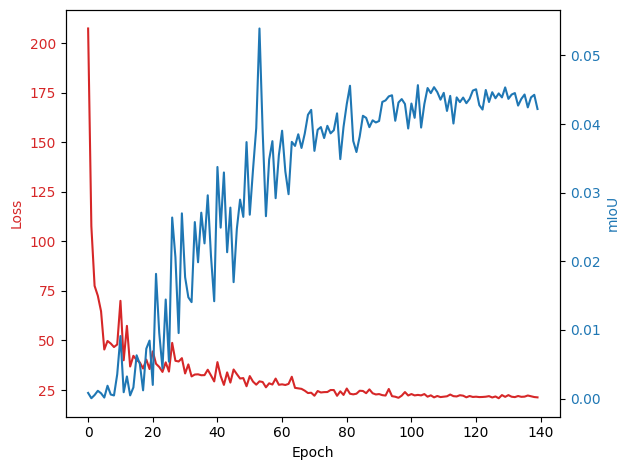

Training epoch 140


100%|██████████| 75/75 [00:34<00:00,  2.15batch/s, loss=11.4]


- Log loss: 21.205997467041016
- mIoU: 0.04521848261356354
Training epoch 141


100%|██████████| 75/75 [00:35<00:00,  2.09batch/s, loss=11.8]


- Log loss: 21.761003494262695
- mIoU: 0.04246866703033447
Training epoch 142


100%|██████████| 75/75 [00:33<00:00,  2.22batch/s, loss=4.73]


- Log loss: 21.4752197265625
- mIoU: 0.045496389269828796
Training epoch 143


100%|██████████| 75/75 [00:26<00:00,  2.80batch/s, loss=4.68]


- Log loss: 20.97125244140625
- mIoU: 0.04440763592720032
Training epoch 144


100%|██████████| 75/75 [00:27<00:00,  2.70batch/s, loss=16.2]


- Log loss: 21.717697143554688
- mIoU: 0.04106888920068741
Training epoch 145


100%|██████████| 75/75 [00:26<00:00,  2.78batch/s, loss=19.3]


- Log loss: 21.76201820373535
- mIoU: 0.04401513189077377
Training epoch 146


100%|██████████| 75/75 [00:26<00:00,  2.78batch/s, loss=11.6]


- Log loss: 21.621994018554688
- mIoU: 0.04322545975446701
Training epoch 147


100%|██████████| 75/75 [00:26<00:00,  2.78batch/s, loss=9.99]


- Log loss: 20.84368896484375
- mIoU: 0.0467216819524765
Training epoch 148


100%|██████████| 75/75 [00:27<00:00,  2.74batch/s, loss=3.84]


- Log loss: 21.239173889160156
- mIoU: 0.04443557187914848
Training epoch 149


100%|██████████| 75/75 [00:34<00:00,  2.17batch/s, loss=8.66]


- Log loss: 21.267181396484375
- mIoU: 0.04441925883293152


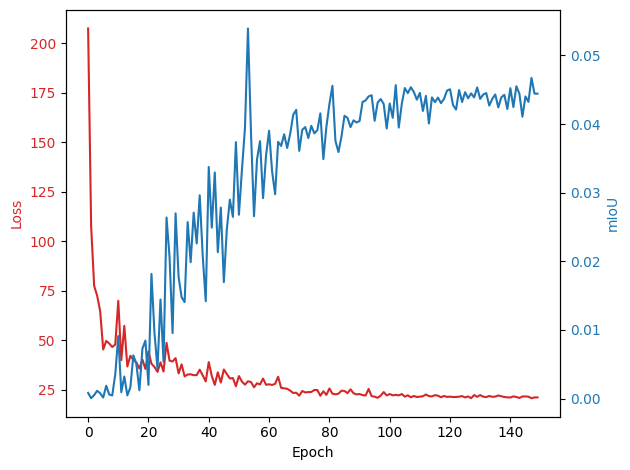

Training complete!


In [10]:
# from models import *
# from trainer import *
# from loader import *
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.multivariate_normal import MultivariateNormal
import sys

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel

#python3 train.py 12 FINAL_12/

# Input arguments
# channels = int(sys.argv[1])
# out_dir = sys.argv[2]

channels = 12
out_dir = '/kaggle/working/train_out/'

# Set up 
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
# model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)
model = model.to(device)
model = nn.DataParallel(model)

# Set up loss function
# loss_fn = MultiScalePoolingLoss(alpha=0.75, gamma=0.0, itr=4, ratio=[0.4, 0.2, 0.2, 0.3])
loss_fn = HausdorffDT_Focal_Loss(focal_weight = 0.65)

train_dataset = MethaneLoader(device = "cuda", mode="train", plume_id=None, channels=channels)
test_dataset = MethaneLoader(device = "cuda", mode="test", plume_id=None, channels=channels)

#print(train_dataset.__len__())

train_loader = DataLoader(train_dataset, 
                          batch_size = 16, 
                          shuffle = True)

test_loader = DataLoader(test_dataset, 
                          batch_size = 16, 
                          shuffle = True)


# Make the trainer
trainer = Trainer(model,
                  train_loader,
                  test_loader,
                  train_dataset,
                  loss_fn,
                  out_dir,
                  1e-4)

# Train
trainer.train(n_epochs=150)

In [11]:
### for clearing directory
### skip it
#!rm -rf /kaggle/working/*

In [12]:
def visualize(idx):
    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)

    print(image1.shape, image2.shape, image3.shape)

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()

In [13]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

# from models import *
# from trainer import *
# from loader import *

from torch.utils.data import DataLoader
from glob import glob

# python3 gen_eval_preds.py 12 final_12_all/ final_12_preds/ 0
# in_dir = sys.argv[2]
# out_dir = sys.argv[3]
# channels = int(sys.argv[1])
# alli_yn = bool(int(sys.argv[4]))

in_dir = "/kaggle/working/train_out/"
out_dir = "/kaggle/working/eval_out/"
channels = 12
alli_yn = False

print("Loading losses...")
losses = np.load(in_dir+"losses.npy")
best_epoch = np.argmin(losses)
print('best epoch: ', best_epoch)

device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
# model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)
model = model.to(device)
model = nn.DataParallel(model)

model.load_state_dict(torch.load(in_dir+"final_model",
                      map_location=torch.device('cuda'))["model_state_dict"])
# model.load_state_dict(torch.load('/kaggle/input/ch4net_attention/pytorch/default/1/final_model',
#                       map_location=torch.device('cuda'))["model_state_dict"])
model.eval()
print()

Loading losses...
best epoch:  147


/tmp/ipykernel_36/1094549648.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(in_dir+"final_model",


In [14]:
import torch
import numpy as np

def calculate_iou(pred, target):
    """
    Calculate Intersection over Union (IoU)
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_accuracy(pred, target):
    """
    Calculate pixel-wise accuracy
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    correct = np.sum(pred == target)
    total = pred.size
    return correct / total

In [15]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import balanced_accuracy_score

def calculate_metrics(pred, target, epsilon=1e-6):
    """
    Calculate IoU, Accuracy, Recall, Balanced Accuracy, False Positive Rate, and False Negative Rate
    """
    pred = F.sigmoid(torch.tensor(pred)).numpy()
    pred = pred > 0.5 # Convert to binary mask
    target = target > 0  # Convert to binary mask
    
    true_positive = np.sum(np.logical_and(pred, target))
    false_positive = np.sum(np.logical_and(pred, np.logical_not(target)))
    false_negative = np.sum(np.logical_and(np.logical_not(pred), target))
    true_negative = np.sum(np.logical_and(np.logical_not(pred), np.logical_not(target)))
    
    # IoU
    union = np.sum(np.logical_or(pred, target))
    iou = (true_positive + epsilon) / (union + epsilon)
    
    # Accuracy
    total = pred.size
    accuracy = (true_positive + true_negative) / total
    
    # Recall (True Positive Rate)
    recall = (true_positive + epsilon) / (true_positive + false_negative + epsilon)
    
    # False Positive Rate
    fpr = (false_positive + epsilon) / (false_positive + true_negative + epsilon)
    
    # False Negative Rate
    fnr = (false_negative + epsilon) / (false_negative + true_positive + epsilon)
    
    # Balanced Accuracy
#     balanced_acc = balanced_accuracy_score(target.flatten(), pred.flatten())
    balanced_acc = None
    
    return iou, accuracy, recall, balanced_acc, fpr, fnr

# ... [Previous imports and setup code remains the same]

losses = []
ious = []
accuracies = []
recalls = []
balanced_accs = []
fprs = []
fnrs = []

# Iterate over each plume
for i in tqdm(range(250)):
    preds = []
    targets = []

    test_dataset = MethaneLoader(
        device="cuda", mode="val", alli=alli_yn, plume_id=i, channels=channels)

    val_loader = DataLoader(test_dataset,
                            batch_size=64,
                            shuffle=False)

    for batch in val_loader:
        out = model(batch["pred"])
        preds.append(np.squeeze(out).cpu())
        targets.append(np.squeeze(batch["target"]).cpu())
        loss_val = loss_fn(np.squeeze(out).unsqueeze(0), np.squeeze(batch["target"]).unsqueeze(0))
        losses.append(loss_val.item())
        
    if len(preds) > 0:
        preds = torch.concat(preds, dim=0).detach().numpy()
        targets = torch.concat(targets, dim=0).detach().numpy()

        # Calculate metrics for this plume
        iou, accuracy, recall, balanced_acc, fpr, fnr = calculate_metrics(preds, targets)
        
        ious.append(iou)
        accuracies.append(accuracy)
        recalls.append(recall)
        balanced_accs.append(balanced_acc)
        fprs.append(fpr)
        fnrs.append(fnr)
        
        preds = F.sigmoid(torch.tensor(preds)).numpy()
        preds = preds > 0.5 # Convert to binary mask
        np.save(out_dir+f"out_{i}.npy", preds)
        np.save(out_dir+f"target_{i}.npy", targets)

# Calculate and print overall metrics
mean_loss = np.mean(losses)
mean_iou = np.mean(ious)
mean_accuracy = np.mean(accuracies)
mean_recall = np.mean(recalls)
# mean_balanced_acc = np.mean(balanced_accs)
mean_fpr = np.mean(fprs)
mean_fnr = np.mean(fnrs)

print(f"Mean Loss: {mean_loss:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
# print(f"Mean Balanced Accuracy: {mean_balanced_acc:.4f}")
print(f"Mean False Positive Rate: {mean_fpr:.4f}")
print(f"Mean False Negative Rate: {mean_fnr:.4f}")

# Save metrics
np.save(out_dir+"metrics.npy", {
    "loss": mean_loss,
    "iou": mean_iou,
    "accuracy": mean_accuracy,
    "recall": mean_recall,
#     "balanced_accuracy": mean_balanced_acc,
    "false_positive_rate": mean_fpr,
    "false_negative_rate": mean_fnr
})

100%|██████████| 250/250 [00:41<00:00,  5.96it/s]

Mean Loss: 32.9623
Mean IoU: 0.5619
Mean Accuracy: 0.9826
Mean Recall: 0.7084
Mean False Positive Rate: 0.0069
Mean False Negative Rate: 0.8057


neg
100.0


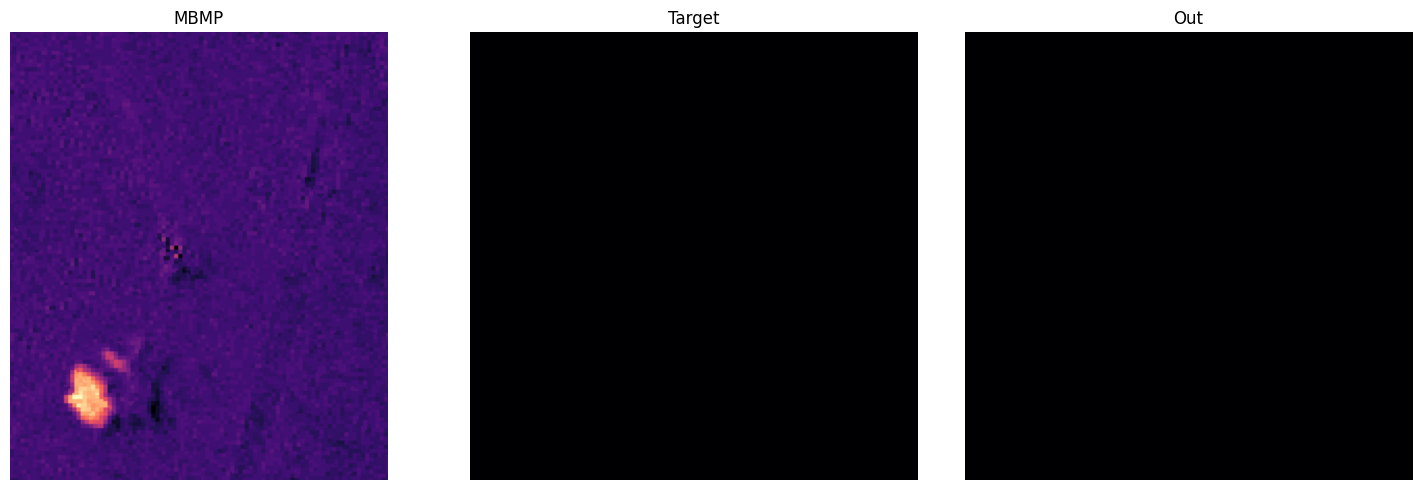

neg
100.0


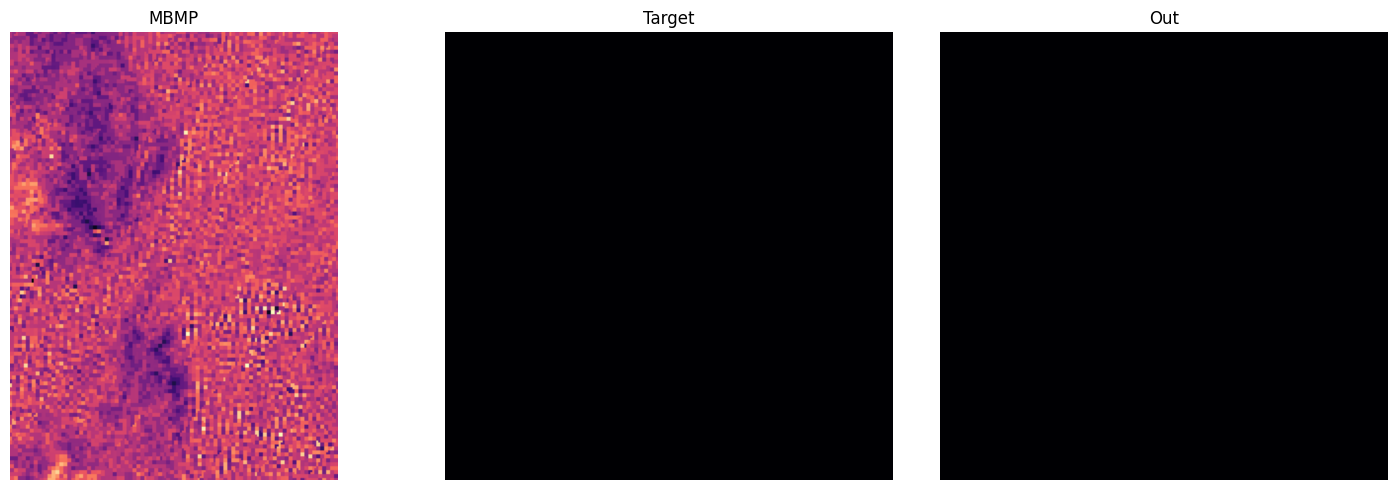

pos
64.12930139298301


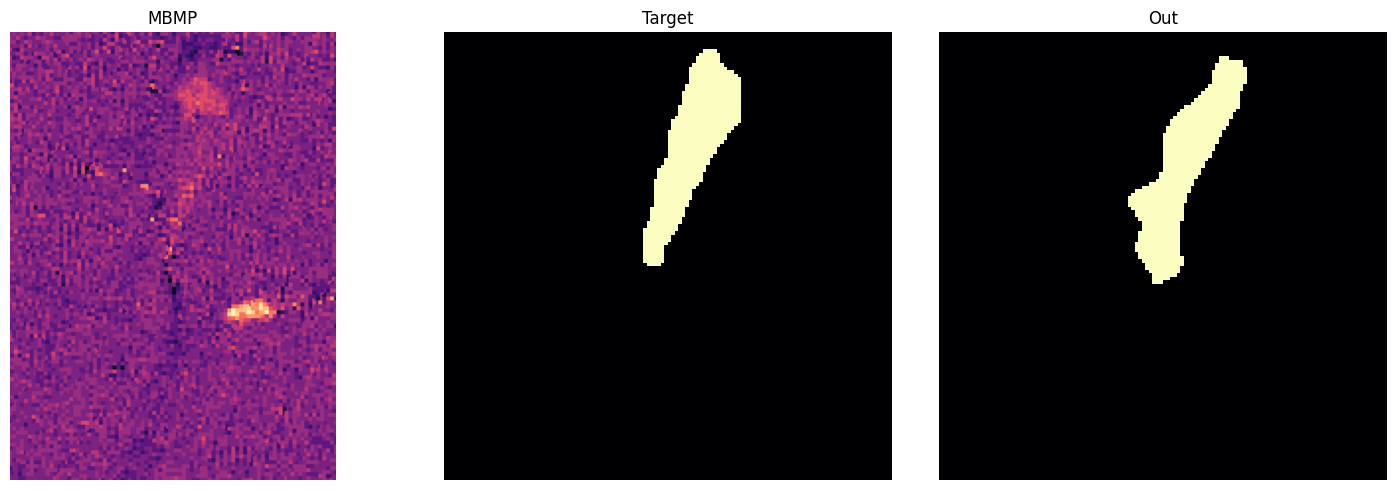

pos
60.40609142080445


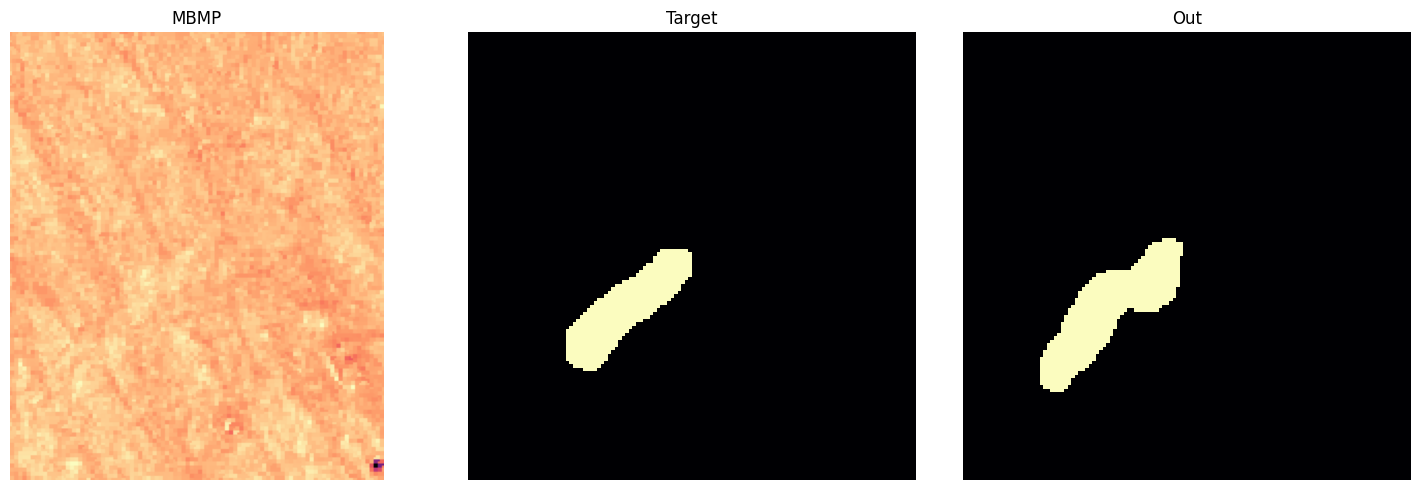

pos
1.9841269801902244e-07


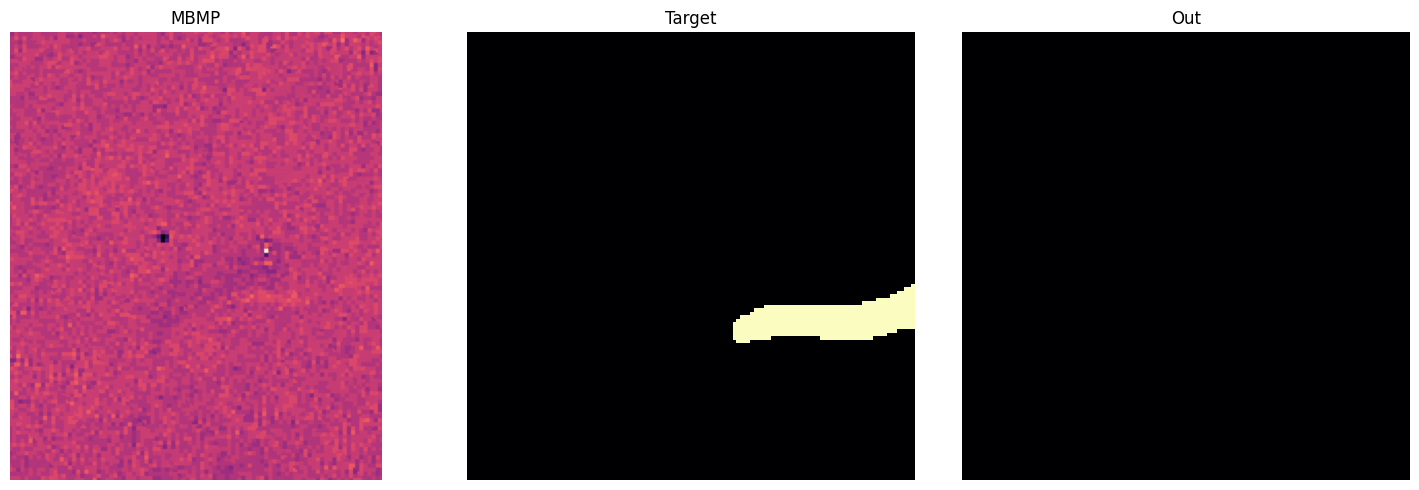

pos
44.080604674859934


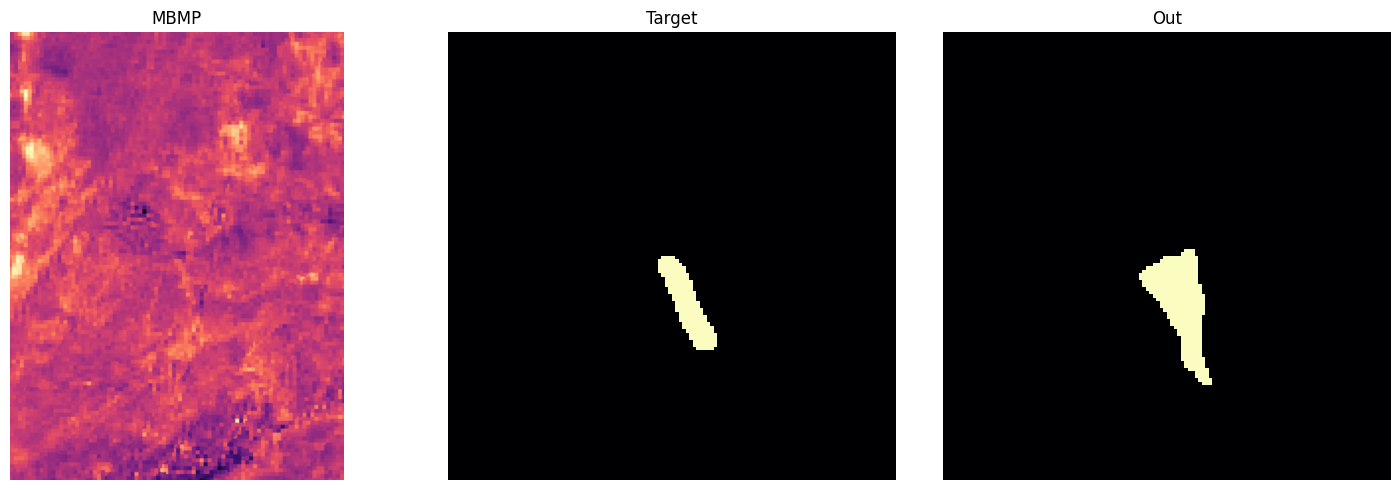

neg
7.936507873519779e-07


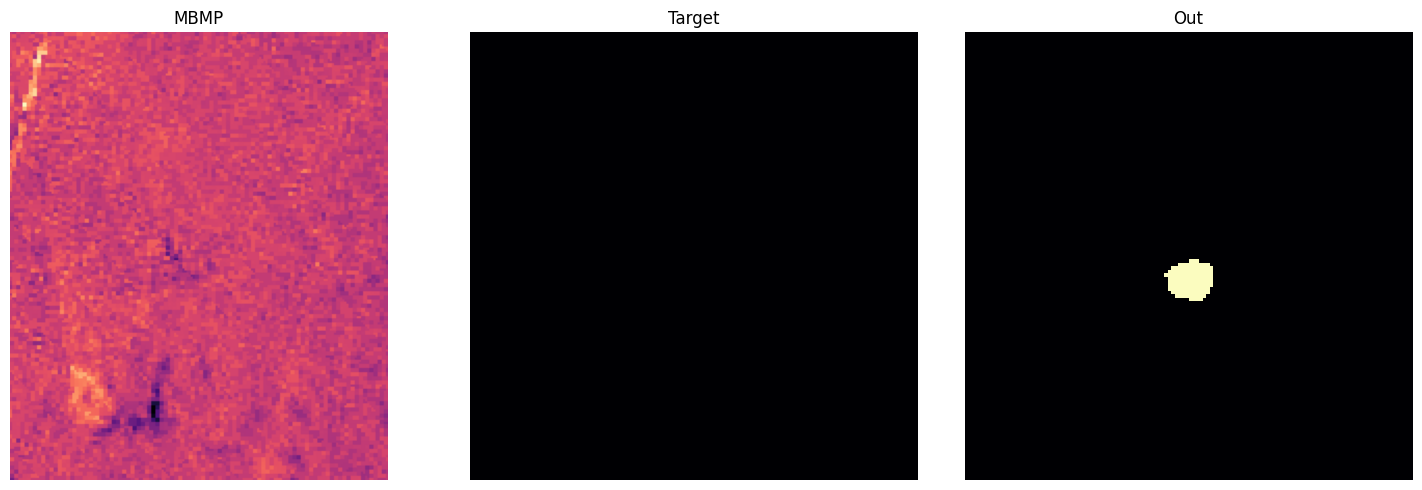

neg
100.0


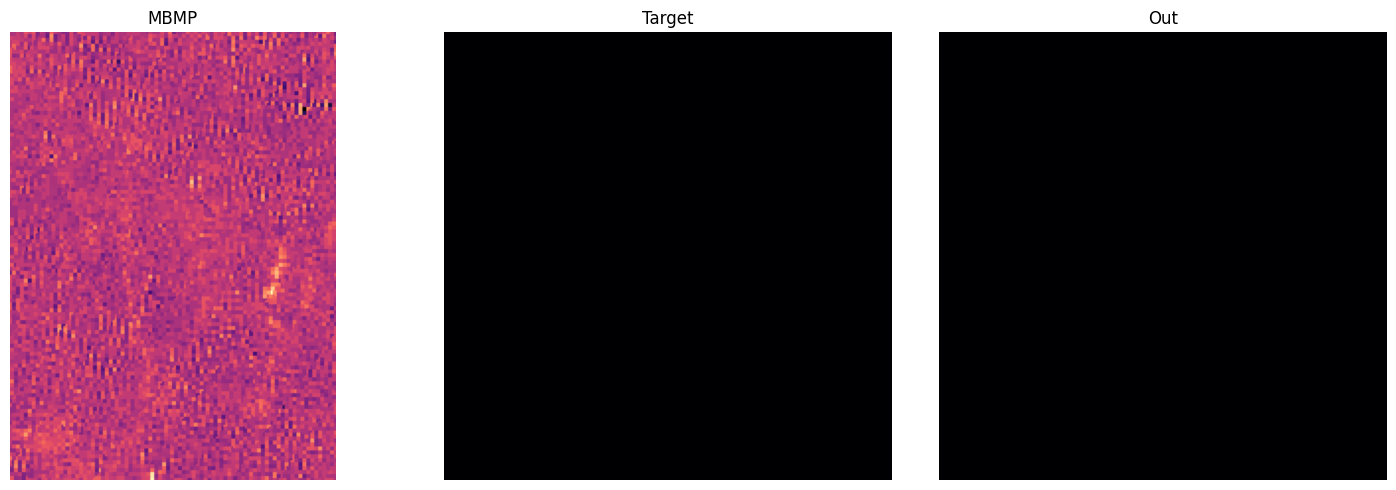

pos
62.457337948025014


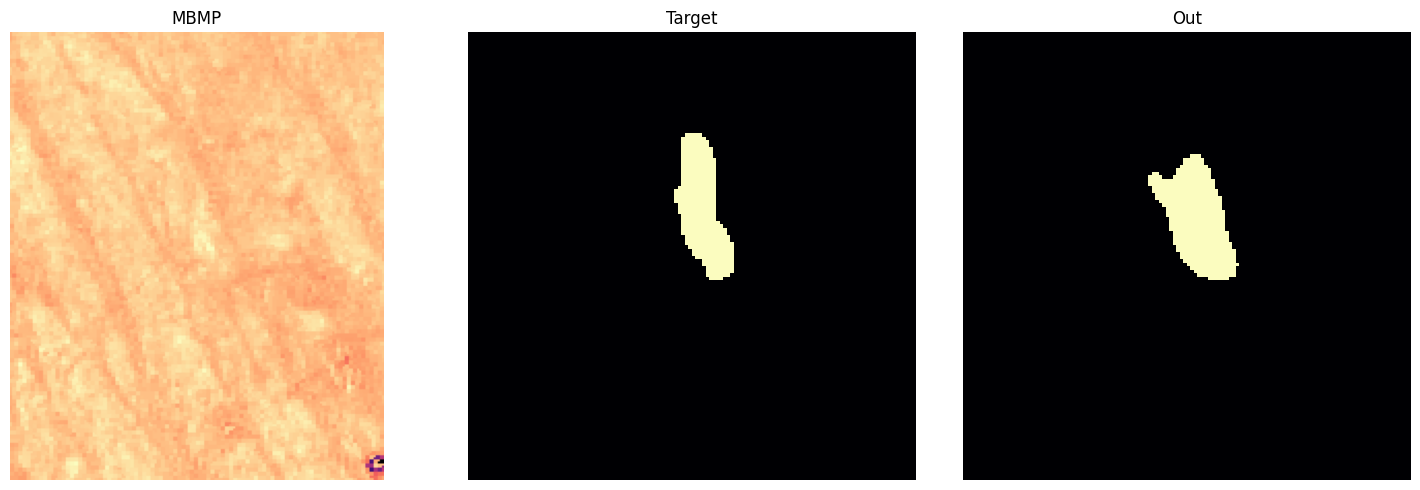

neg
100.0


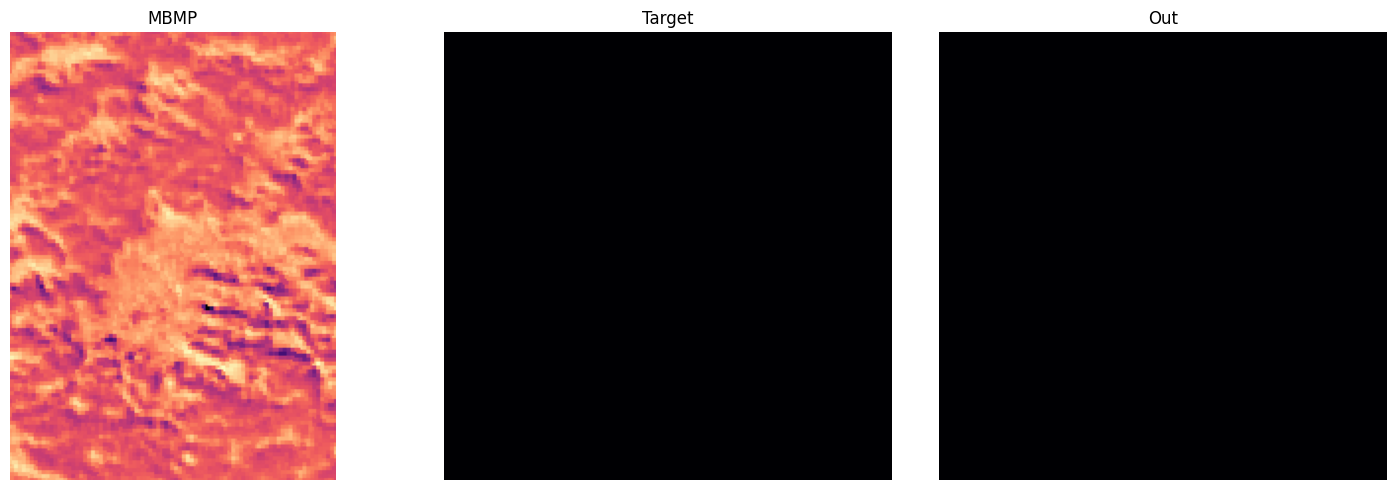

neg
100.0


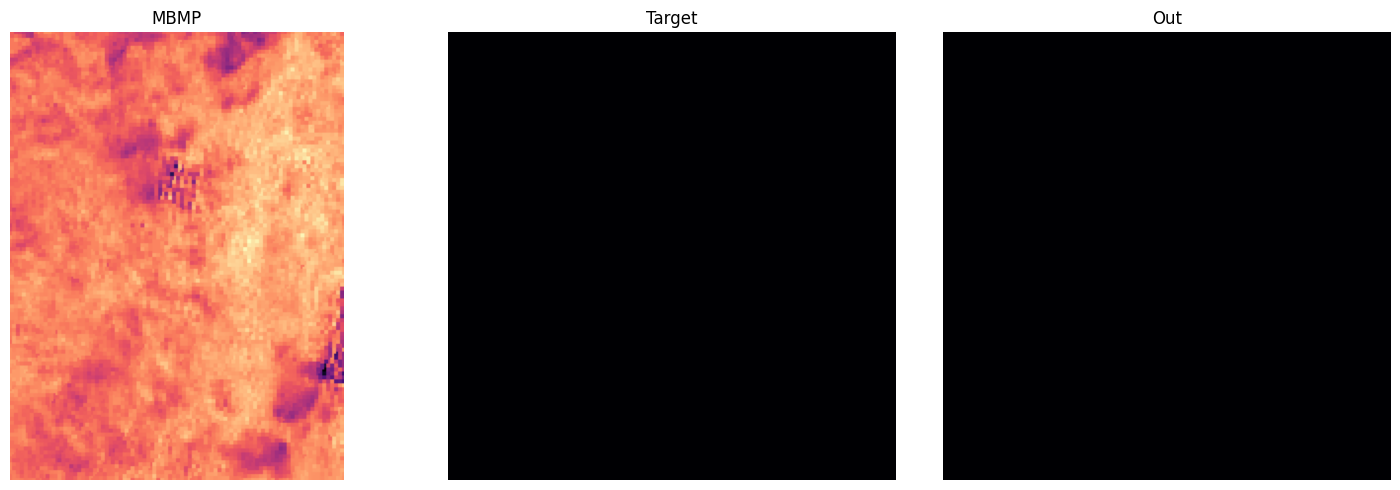

neg
100.0


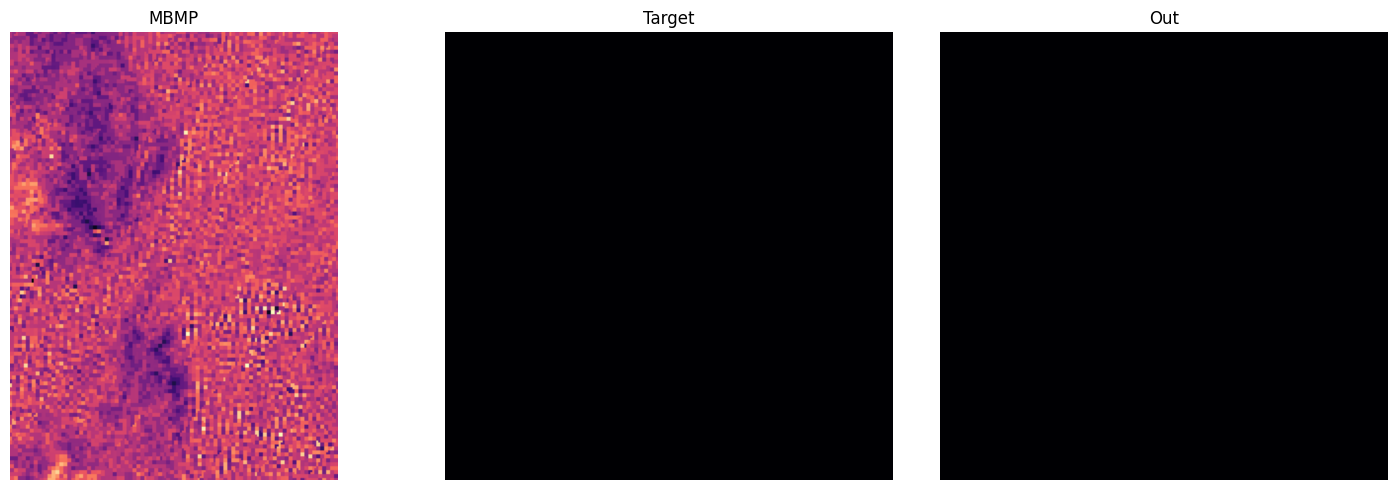

pos
45.084745824763


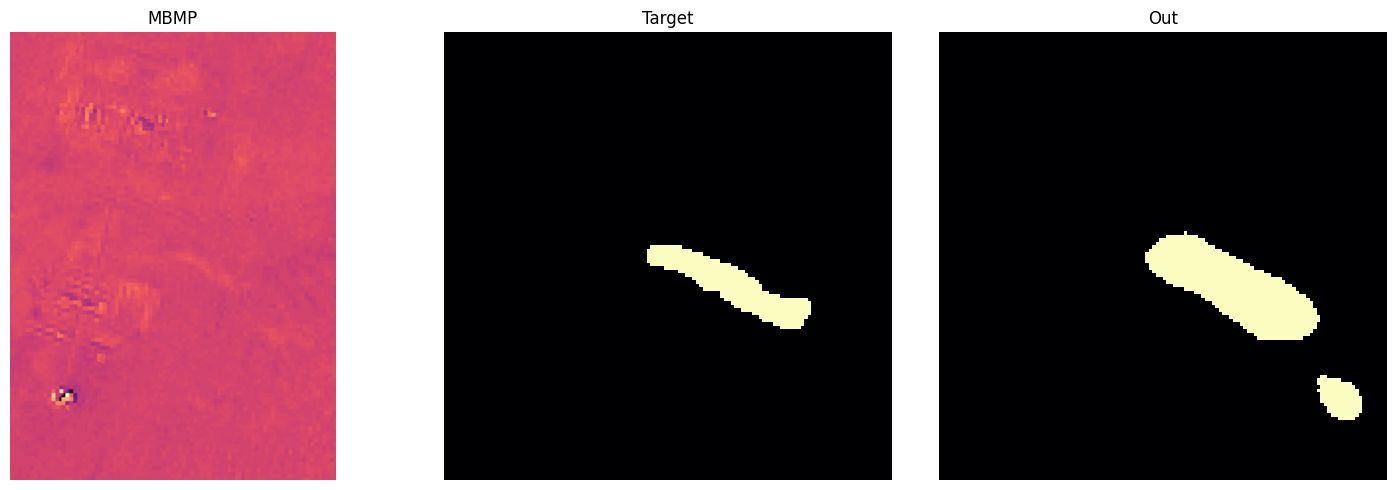

pos
25.770308175230877


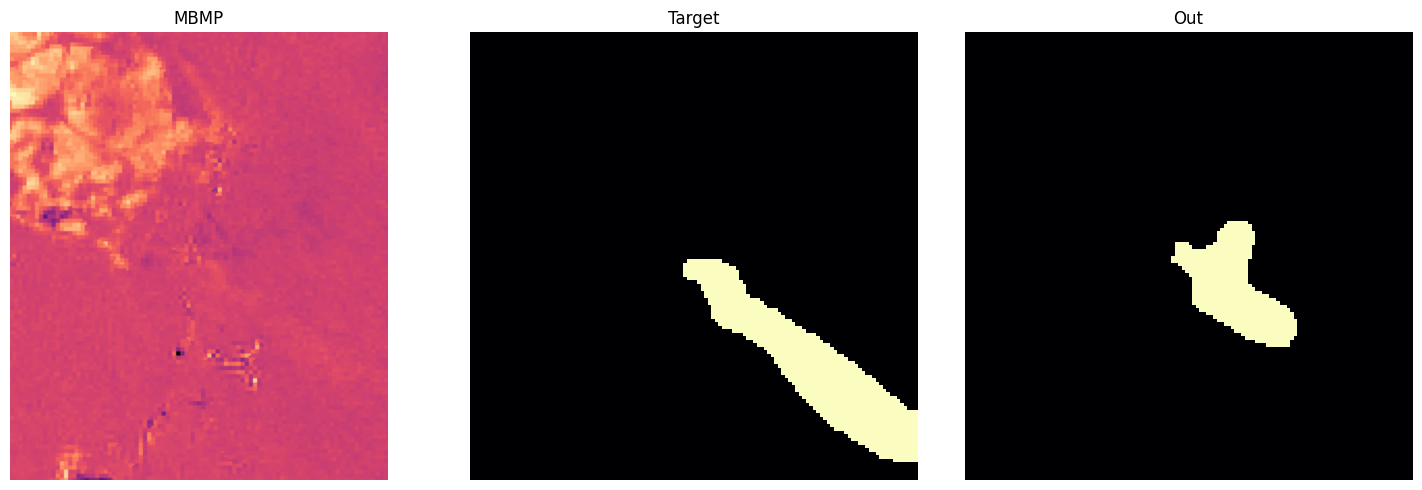

pos
1.7331022500292854e-07


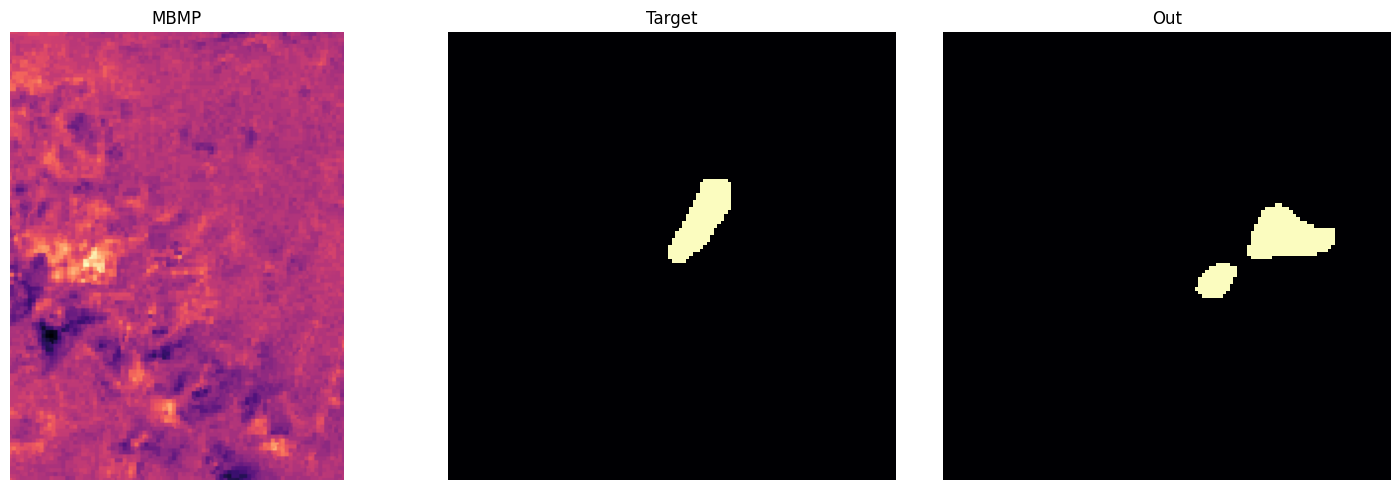

neg
100.0


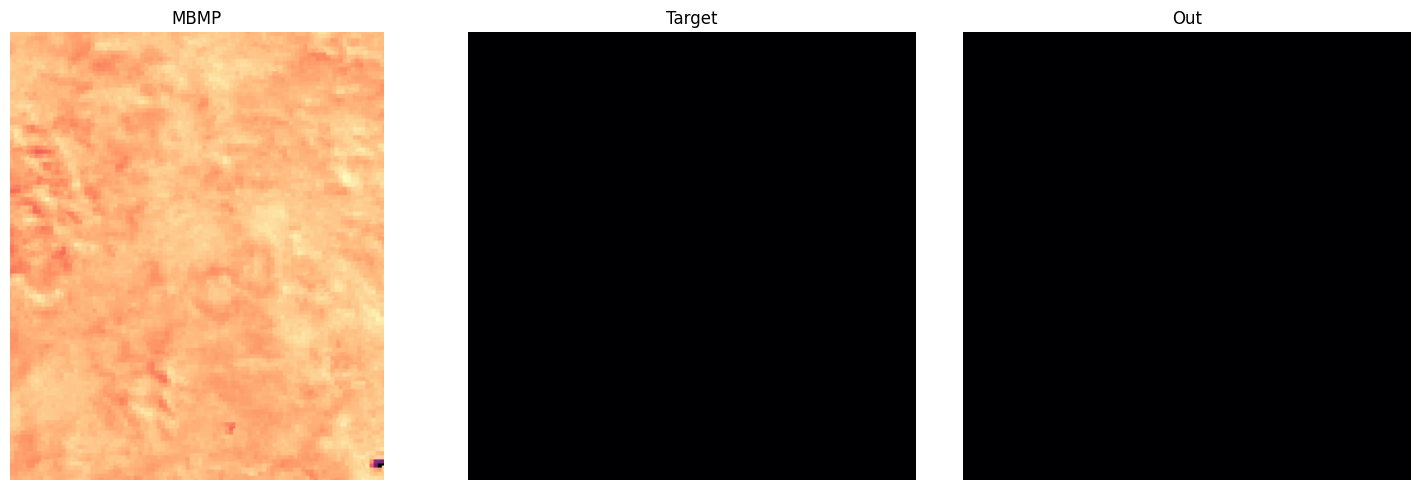

neg
100.0


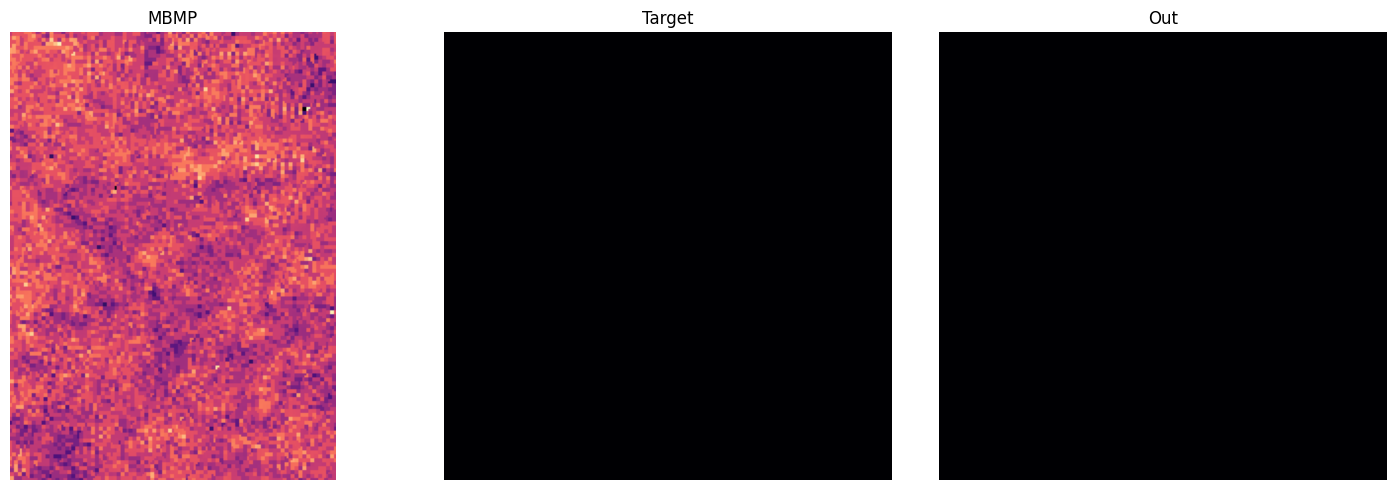

neg
100.0


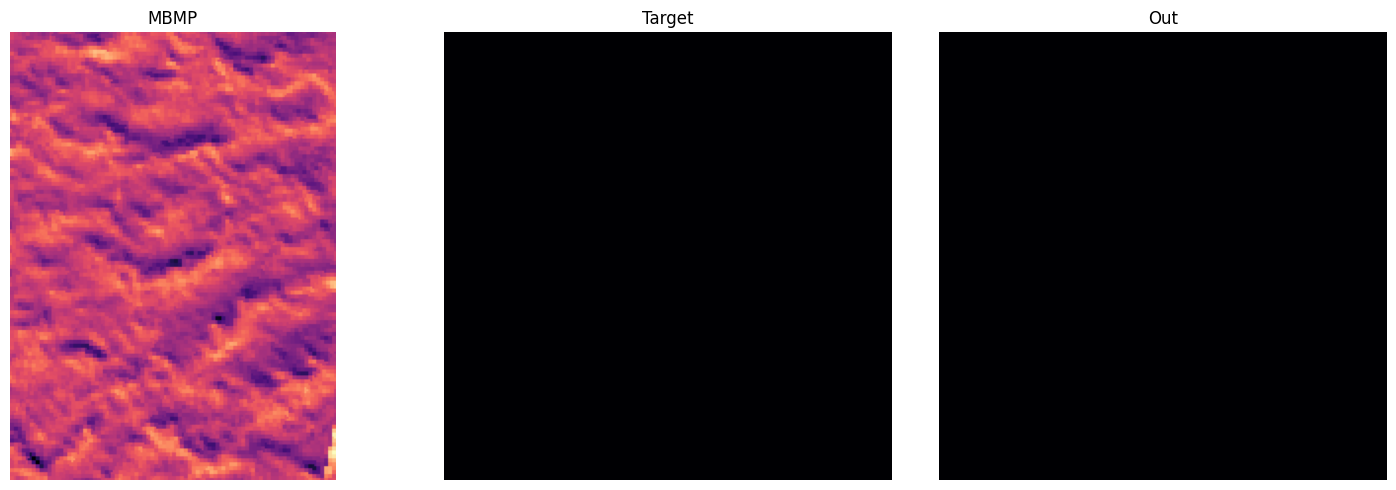

neg
100.0


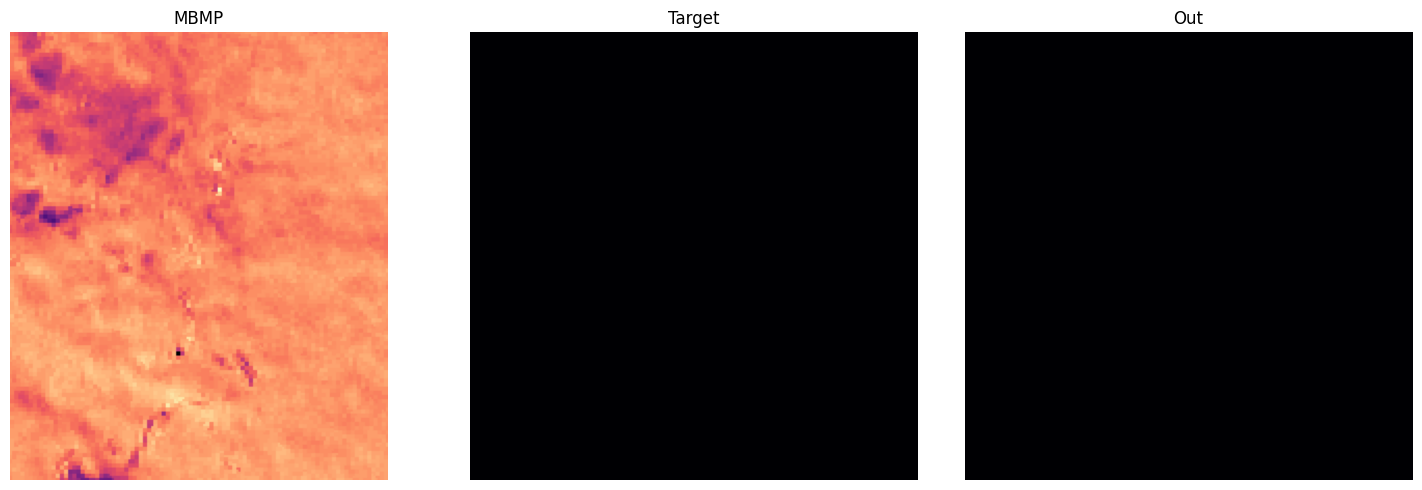

neg
100.0


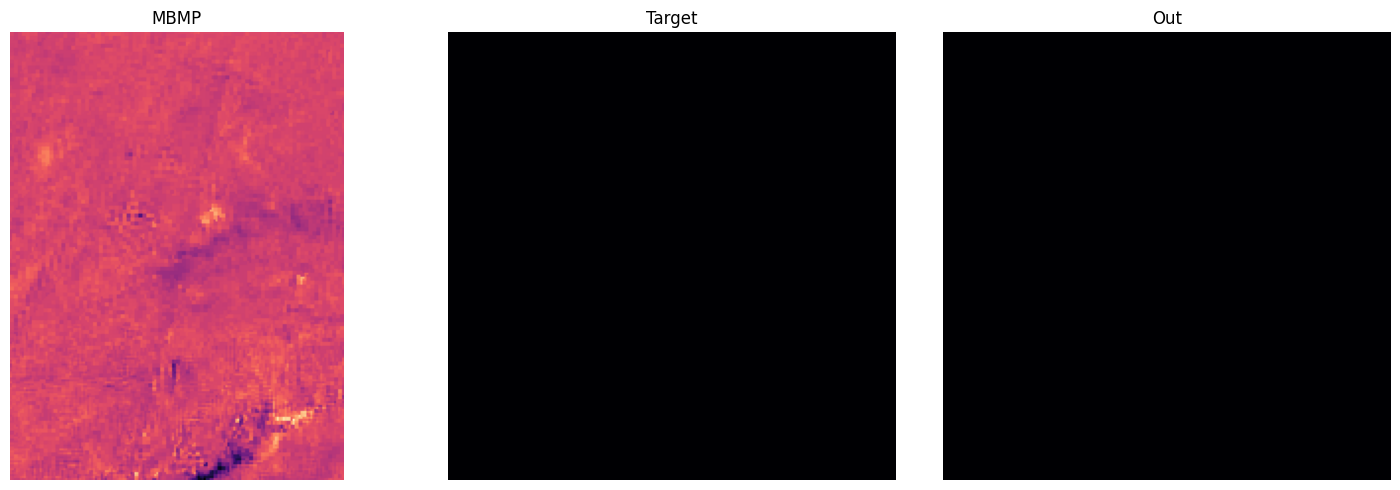

In [16]:
# from glob import glob

# visualize masks
samples = 250

# def visualize(idx):
    
for i in range(samples):
    idx = np.random.randint(0, samples)
#     idx = i

    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)
#     print(image2.shape)
    
    eps = 1e-6
    pred = image3
    target = image2
    iou = (np.sum(np.logical_and(pred, target)) + eps) / (np.sum(np.logical_or(pred, target)) + eps) * 100
    
    print(iou)

#     print(image1.shape, image2.shape, image3.shape)
#     print(losses[idx])

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()
    
    i = i + 1
    if(i==20): break
